## la préparation des données et le feature engineering : 

### https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features

### 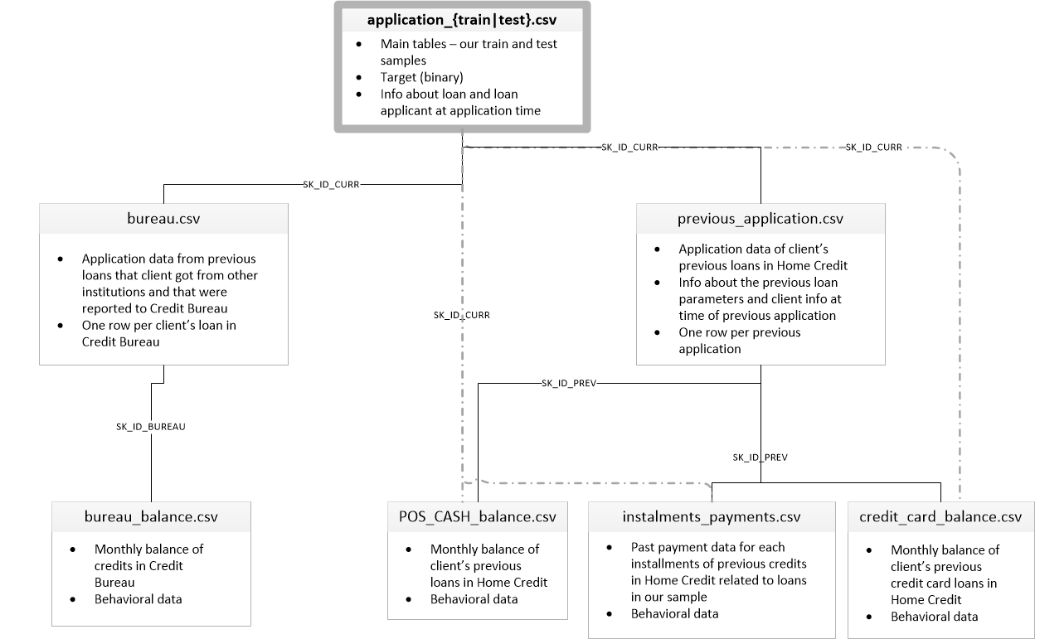

### Je souhaite que vous puissiez mettre en oeuvre au minimum les étapes orientées MLOps suivantes : 

Dans le notebook d’entraînement des modèles, générer à l’aide de MLFlow un tracking d'expérimentations. 
Lancer l’interface web 'UI MLFlow" d'affichage des résultats du tracking. 
Réaliser avec MLFlow un stockage centralisé des modèles dans un “model registry”. 
Tester le serving MLFlow. 
Gérer le code avec le logiciel de version Git. 
Partager le code sur Github pour assurer une intégration continue. 
Utiliser Github Actions pour le déploiement continu et automatisé du code de l’API sur le cloud. 
Concevoir des tests unitaires avec Pytest (ou Unittest) et les exécuter de manière automatisée lors du build réalisé par Github Actions

## Feature engineering

#### Option 1 
https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
# from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
# from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    train_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\application_train.csv"
    test_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\application_test.csv"
    df = pd.read_csv(train_path, nrows=num_rows)
    test_df = pd.read_csv(test_path, nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    # df = df.append(test_df).reset_index()
    df = pd.concat([df, test_df]).reset_index(drop=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\bureau.csv"
    bureau = pd.read_csv(bureau_path, nrows=num_rows)
    bb_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\bureau_balance.csv"
    bb = pd.read_csv(bb_path, nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\previous_application.csv"
    prev = pd.read_csv(prev_path, nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\POS_CASH_balance.csv"
    pos = pd.read_csv(pos_path, nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\installments_payments.csv"
    ins = pd.read_csv(ins_path, nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\credit_card_balance.csv"
    cc = pd.read_csv(cc_path, nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    print("Initial df shape:", df.shape)  # Print the shape of df to confirm it's loaded

    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        print("df after joining bureau:", df.shape)
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        print("df after joining previous applications:", df.shape)
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        print("df after joining pos:", df.shape)
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        print("df after joining installments payments:", df.shape)
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        print("df after joining credit card balance:", df.shape)
        del cc
        gc.collect()
    # with timer("Run LightGBM with kfold"):
    #     feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)
    return df  # Ajout du retour

if __name__ == "__main__":
    with timer("Full model run"):
        df = main()
    print("Final DataFrame shape:", df.shape)

Train samples: 307511, test samples: 48744
Initial df shape: (356251, 247)
Bureau df shape: (305811, 116)
df after joining bureau: (356251, 363)
Process bureau and bureau_balance - done in 39s
Previous applications df shape: (338857, 249)
df after joining previous applications: (356251, 612)
Process previous_applications - done in 48s
Pos-cash balance df shape: (337252, 18)
df after joining pos: (356251, 630)
Process POS-CASH balance - done in 30s
Installments payments df shape: (339587, 26)
df after joining installments payments: (356251, 656)
Process installments payments - done in 49s
Credit card balance df shape: (103558, 141)
df after joining credit card balance: (356251, 797)
Process credit card balance - done in 42s
Full model run - done in 220s
Final DataFrame shape: (356251, 797)


In [2]:
df.shape

(356251, 797)

In [3]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=797)

#### Conversion en valeurs numériques

In [4]:
# conversion de toutes les colonnes du DataFrame df en valeurs numériques, tout en gérant les erreurs éventuelles (en cas de valeur non convertible, cette valeur doit être remplacée par NaN)

df = df.apply(pd.to_numeric, errors='coerce')

#### Gestion des inf

In [5]:
# Vérifiez si des valeurs infinies sont présentes
print(f"Nombre de valeurs infinies dans df: {np.isinf(df).sum().sum()}")

# Vérifiez si des valeurs NaN sont présentes
print(f"Nombre de valeurs NaN dans df: {np.isnan(df).sum().sum()}")

# Vérifiez les valeurs trop grandes
print(f"Valeur maximale dans df: {np.max(df)}")

Nombre de valeurs infinies dans df: 61
Nombre de valeurs NaN dans df: 72099941
Valeur maximale dans df: inf


In [6]:
# Remplacez les infinis par NaN pour les traiter ensemble
df[np.isinf(df)] = np.nan

#### Suppression des colonnes et lignes NA
On supprimes les colonnes et les lignes avec beaucoup de données manquantes (contiennent plus de 40 % de valeurs manquantes (NaN). )

In [7]:
df.shape

(356251, 797)

In [8]:
# nb de colonnes contenant plus de 40 % de valeurs manquantes (Nan)
(df.isna().mean()>0.4).sum()

245

In [9]:
#  calcule la proportion de valeurs manquantes (NaN) dans la colonne TARGET
df.TARGET.isna().mean()

0.1368248790880587

In [10]:
# Garder uniquement les colonnes qui contiennent au plus 40 % de valeurs manquantes.
df = df.loc[:, df.isna().mean() <= 0.4]

In [11]:
# Supprimer les lignes contenant plus de 40 % de valeurs manquantes
df = df.loc[df.T.isna().mean() <= 0.4, :]

In [12]:
df.shape

(339232, 552)

### Remplacement des valeurs manquantes

In [13]:
# Remplacer les valeurs manquantes uniquement dans les colonnes autres que TARGET
X = df.drop(columns=['TARGET'])
X = X.fillna(X.median())  # Remplir les valeurs manquantes des colonnes explicatives

In [14]:
# Préparer la variable cible sans modification
y = df['TARGET']

### Séparation en jeu d'entraînement et jeu de test

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Vérifiez les valeurs NaN dans y_test
if pd.isnull(y_test).any():
    print("y_test contient des valeurs NaN.")

y_test contient des valeurs NaN.


In [17]:
#supprimer les lignes où y_test est NaN (et potentiellement ajuster X_test pour correspondre)
X_test = X_test[~pd.isnull(y_test)]
y_test = y_test.dropna()

In [16]:
# from sklearn.dummy import DummyClassifier
# from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# # 1. Initialiser le Dummy Classifier avec une stratégie
# dummy_model = DummyClassifier(strategy="most_frequent")  # Prédit toujours la classe majoritaire
# # Autres stratégies possibles :
# # - "stratified" : Prédictions proportionnelles à la répartition des classes
# # - "uniform" : Prédictions aléatoires
# # - "constant" : Prédit une classe constante spécifiée par `constant=<valeur>`

# # 2. Entraîner le modèle sur les données d'entraînement
# dummy_model.fit(X_train, y_train)

# # 3. Faire des prédictions
# y_pred = dummy_model.predict(X_test)

# # 4. Évaluer le modèle
# accuracy = accuracy_score(y_test, y_pred)
# cm = confusion_matrix(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print("Dummy Classifier Performance:")
# print(f"Accuracy: {accuracy:.2f}")
# print("Confusion Matrix:")
# print(cm)
# print("Classification Report:")
# print(report)

# # 5. Calculer l'AUC si possible (nécessite des probabilités)
# if len(y.unique()) == 2:  # Vérification binaire
#     y_proba = dummy_model.predict_proba(X_test)[:, 1]
#     auc = roc_auc_score(y_test, y_proba)
#     print(f"AUC-ROC: {auc:.2f}")


### Entraînement et suivi avec MLFlow : Exemple avec un modèle RandomForest

### Mise en place de MLFlow pour le tracking des experimentations

In [38]:
pip install mlflow


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Le code permet de suivre tout le cycle d'une expérimentation avec MLFlow, notamment :

Les hyperparamètres utilisés pour configurer le modèle.
Les métriques de performance pour évaluer le modèle.
Le modèle lui-même pour être réutilisé ultérieurement.

In [39]:
import mlflow
mlflow.set_tracking_uri("http://localhost:5001")

#### Démarrez l'interface MLFlow en bash en mettant le code
mlflow server --host 0.0.0.0 --port 5001

ouvrir une page web avec http://localhost:5001


In [19]:
pip install lightgbm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Evaliation des modèles sans SMOTE

### Dummy classifier (testé avec train/test)

In [40]:
import mlflow
import mlflow.sklearn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialiser le Dummy Classifier avec une stratégie
dummy_model = DummyClassifier(strategy="most_frequent")  # Prédit toujours la classe majoritaire

# 2. Entraîner le modèle sur les données d'entraînement
dummy_model.fit(X_train, y_train)

# 3. Faire des prédictions
y_pred = dummy_model.predict(X_test)

# 4. Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Dummy Classifier Performance:")
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(report)

# 5. Calculer l'AUC si possible (nécessite des probabilités)
auc = None
if len(y.unique()) == 2:  # Vérification binaire
    y_proba = dummy_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC-ROC: {auc:.2f}")

# 6. Intégration avec MLflow
with mlflow.start_run(run_name="DummyClassifier"):
    # Enregistrer les paramètres du modèle
    mlflow.log_param("model_strategy", "most_frequent")
    
    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    if auc is not None:
        mlflow.log_metric("auc", auc)
    
    # Enregistrer le rapport de classification comme artefact
    with open("classification_report.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("classification_report.txt")
    
    # Enregistrer la matrice de confusion sous forme d'image
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("confusion_matrix.png")
    
    # Enregistrer le modèle
    mlflow.sklearn.log_model(dummy_model, "dummy_model")

print("Résultats enregistrés dans MLflow.")


C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Dummy Classifier Performance:
Accuracy: 0.92
Confusion Matrix:
[[53403     0]
 [ 4875     0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     53403
         1.0       0.00      0.00      0.00      4875

    accuracy                           0.92     58278
   macro avg       0.46      0.50      0.48     58278
weighted avg       0.84      0.92      0.88     58278



2024/12/09 09:37:12 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2024/12/09 09:37:34 WARNING mlflow.models.model: Model logged without a signature and input example. Ple

🏃 View run DummyClassifier at: http://localhost:5001/#/experiments/0/runs/3b1e87ac97ee4aac91f2fb640a2ea829
🧪 View experiment at: http://localhost:5001/#/experiments/0
Résultats enregistrés dans MLflow.


### Réduction de l'utilisation de la mémoire

In [41]:
def reduce_memory_usage(df):
    """
    Réduit l'utilisation de la mémoire par un DataFrame.
    """
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'int64':
            df[col] = df[col].astype('int32')
    return df

# Réduction de mémoire pour X
X = reduce_memory_usage(X)


### LogisticRegression, RandomForest et LightGBM

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, accuracy_score
import lightgbm as lgb
import mlflow
import mlflow.sklearn
import numpy as np
import gc

In [43]:
# Fonction de coût métier
def compute_business_cost(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Calcule le coût métier basé sur les FN et FP.
    :param y_true: Vérités terrain.
    :param y_pred: Prédictions binaires.
    :param cost_fn: Coût d'un faux négatif.
    :param cost_fp: Coût d'un faux positif.
    :return: Coût total métier.
    """
    cm = confusion_matrix(y_true, y_pred)
    fn = cm[1, 0]  # Faux négatifs
    fp = cm[0, 1]  # Faux positifs
    return cost_fn * fn + cost_fp * fp

In [50]:
# Custom scorer pour GridSearch
def business_cost_scorer(y_true, y_pred):
    return -compute_business_cost(y_true, y_pred)

business_cost_scorer_func = make_scorer(business_cost_scorer, greater_is_better=False)

# Modèles et hyperparamètres pour GridSearchCV
models = {
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, max_iter=1000),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__penalty": ["l2"],
            "model__solver": ["lbfgs"]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50, 100],  # Réduire le nombre d'arbres
            "model__max_depth": [10, None],    # Limiter la profondeur des arbres
            "model__max_features": ["sqrt", "log2"],  # Réduire les variables à considérer pour chaque split
            "model__min_samples_split": [2, 10],  # Augmenter pour réduire la complexité des arbres
            "model__min_samples_leaf": [1, 10],    # Augmenter pour limiter la taille des feuilles
            "model__max_samples": [0.5, 0.8]  # Utilise 50 % ou 80 % des données pour chaque arbre

        }
    },
    "LightGBM": {
        "model": lgb.LGBMClassifier(random_state=42),
        "params": {
            "model__learning_rate": [0.05, 0.1],
            "model__n_estimators": [50, 100],
            "model__is_unbalance": [True, False]
        }
    }
}

In [51]:
# Pipeline standardisation + modèle
def create_pipeline(model):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])

In [52]:
# Vérifiez les valeurs NaN dans y_test
if pd.isnull(y).any():
    print("y contient des valeurs NaN.")

In [53]:
#supprimer les lignes où y est NaN (et potentiellement ajuster X pour correspondre)
X = X[~pd.isnull(y)]
y = y.dropna()

In [ ]:
# Itération sur chaque modèle
for model_name, model_info in models.items():
    print(f"Testing {model_name}...")
    pipeline = create_pipeline(model_info["model"])
    grid = GridSearchCV(
        pipeline,
        model_info["params"],
        scoring=business_cost_scorer_func,
        cv=3,  # 3-fold cross-validation
        n_jobs=-1
    )
    
    # Entraînement avec GridSearchCV
    grid.fit(X, y)
    
    # Meilleur modèle et prédictions
    best_model = grid.best_estimator_
    y_proba = best_model.predict_proba(X)[:, 1]
    
    # Optimisation du seuil pour minimiser le coût métier
    best_threshold = 0.5
    min_cost = float("inf")
    for threshold in np.arange(0.1, 0.9, 0.01):
        y_pred = (y_proba >= threshold).astype(int)
        cost = compute_business_cost(y, y_pred)
        if cost < min_cost:
            min_cost = cost
            best_threshold = threshold
    
    # Prédictions finales
    final_predictions = (y_proba >= best_threshold).astype(int)
    
    # Évaluation finale
    accuracy = accuracy_score(y, final_predictions)
    roc_auc = roc_auc_score(y, y_proba)
    business_cost = compute_business_cost(y, final_predictions)
    
    print(f"Model: {model_name}")
    print(f"Best Threshold: {best_threshold}")
    print(f"Accuracy: {accuracy:.2f}, ROC-AUC: {roc_auc:.2f}, Business Cost: {business_cost}")
    
    # Logging dans MLflow
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("best_threshold", best_threshold)
        mlflow.log_params(grid.best_params_)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("roc_auc", roc_auc)
        mlflow.log_metric("business_cost", business_cost)
        mlflow.sklearn.log_model(best_model, model_name)

    # Libération de la mémoire
    del grid, best_model
    gc.collect()


Testing LogisticRegression...


C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [22]:
from sklearn.model_selection import train_test_split, StratifiedKFold
#from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
#from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_recall_fscore_support

from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import mlflow

import time

In [18]:
def business_scorer(y, y_pred) : 
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    error = 10*fn + fp
    return -error

In [19]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    #show()

In [23]:
scoring = {'business_scorer': make_scorer(business_scorer, greater_is_better=True),  'auc': 'roc_auc'}

In [24]:
#parametres des modèles

param_grid_dm = {'dummyclassifier__strategy' : ['most_frequent', 'prior', 'stratified', 'uniform', 'constant'], 
              'dummyclassifier__constant' : [1]
             }  

param_grid_lc = {'logisticregression__C': [0.1, 1.0, 10.0], 
                 'logisticregression__penalty': ['none', 'l2']
             }  

param_grid_rfc = {'randomforestclassifier__n_estimators': [50, 150], 
              'randomforestclassifier__min_samples_leaf' : [1, 10],
              'randomforestclassifier__min_samples_split' : [2, 10],
              'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
              'randomforestclassifier__max_depth' : [5, 10],
             }  


# param_grid_xgb = {'xgbclassifier__n_estimators': [50, 150],
#               'xgbclassifier__learning_rate': [0.01, 0.1],
#               'xgbclassifier__gamma': [1, 10],
#               'xgbclassifier__max_depth' : [6, 10],
#              }  

param_grid_lgbm = {'lgbmclassifier__learning_rate': [0.05, 0.07, 0.08], 
                   'lgbmclassifier__max_depth': [5, 6, 7], 
                   'lgbmclassifier__n_estimators':[100, 500, 1000] 
                  }  

In [25]:
# les modèles

dc = DummyClassifier(random_state=5)
lr = LogisticRegression(random_state=5)
rfc = RandomForestClassifier(random_state=5)
xgbc = XGBClassifier(random_state=5)
lgbmc = LGBMClassifier(random_state=5, boosting_type = 'goss', objective = 'binary')

In [26]:
def get_scores_and_fitting_time(results) :
    best_cv = results['rank_test_auc'].argmin()
    best_business = results['mean_test_business_scorer'][best_cv]
    best_auc = results['mean_test_auc'][best_cv]
    best_time_fitting = results['mean_fit_time'][best_cv]
    
    return best_business, best_auc, best_time_fitting

In [28]:
X_train

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
151531,275645,0,0,0,0,180000.0,275040.0,13504.5,180000.0,0.008575,...,10420.304362,489754.305,223.065,21709.125,8999.263723,422965.395,-57.0,-821.063830,-38590.0,47.0
160424,285969,1,0,0,0,67500.0,305640.0,31446.0,270000.0,0.035792,...,17707.980000,159371.820,15987.915,31468.500,17707.980000,159371.820,-2353.0,-2498.888889,-22490.0,9.0
203849,336331,1,0,0,0,180000.0,270000.0,13500.0,270000.0,0.004960,...,21958.200000,109791.000,21958.200,21958.200,21958.200000,109791.000,-26.0,-88.600000,-443.0,5.0
300030,447581,1,1,1,0,135000.0,936018.0,30325.5,670500.0,0.019689,...,49064.877422,3140152.155,4898.835,239641.515,48638.972109,3112894.215,-28.0,-1027.796875,-65779.0,64.0
218527,353171,0,0,0,0,135000.0,343287.0,27121.5,310500.0,0.025164,...,16281.171667,439591.635,928.395,67500.000,16281.171667,439591.635,-23.0,-170.333333,-4599.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126568,246787,1,1,0,0,135000.0,624289.5,26581.5,558000.0,0.046220,...,21976.729773,483488.055,1568.790,201873.690,21976.729773,483488.055,-18.0,-224.954545,-4949.0,22.0
274023,417638,0,0,0,1,270000.0,588874.5,28773.0,414000.0,0.046220,...,9515.850882,323538.930,52.200,22500.000,9515.850882,323538.930,-3.0,-134.500000,-4573.0,34.0
139312,261533,1,0,1,0,90000.0,225000.0,22252.5,225000.0,0.011657,...,42897.527500,1544310.990,14567.040,60844.500,42897.527500,1544310.990,-18.0,-762.722222,-27458.0,36.0
155084,279764,1,0,0,0,54000.0,254700.0,14751.0,225000.0,0.007120,...,6040.601250,72487.215,6033.960,6041.205,6040.601250,72487.215,-280.0,-447.083333,-5365.0,12.0


In [31]:
#sc = StandardScaler()
scaler = MinMaxScaler(feature_range = (0, 1))

In [34]:
#supprimer les lignes où y est NaN (et potentiellement ajuster X pour correspondre)
X = X[~pd.isnull(y)]
y = y.dropna()

In [32]:
%%time

with mlflow.start_run(run_name='dummy'):

    pipeline = make_pipeline(scaler, dc)  

    grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid_dm, cv=5, scoring=scoring, refit='business_scorer', return_train_score=True)  
    grid_search.fit(X, y)  
    results = grid_search.cv_results_
    best_business_dc, best_auc_dc, best_time_fitting_dc = get_scores_and_fitting_time(results)
    best_params_dc = grid_search.best_params_  
    
    #best_score_dc = grid_search.best_score_  
    #cf_matrix_roc_auc(grid_search.best_estimator_, data_train_reduit.TARGET, grid_search.best_estimator_.predict(data_train_reduit.drop('TARGET', axis=1)), grid_search.best_estimator_.predict_proba(data_train_reduit.drop('TARGET', axis=1))[:,1])
    #print(classification_report(data_train_reduit.TARGET, grid_search.best_estimator_.predict(data_train_reduit.drop('TARGET', axis=1))))
    
    print("Meilleurs params :", best_params_dc)
    print("Meilleur business score :", best_business_dc)
    print("AUC :", best_auc_dc)
    print("Fitting time", best_time_fitting_dc)
    
    for param_name in best_params_dc:
        mlflow.log_param(param_name, best_params_dc[param_name])
    
    mlflow.log_metric("Business score", best_business_dc)
    mlflow.log_metric('AUC', best_auc_dc)
    mlflow.log_metric('Fit time', best_time_fitting_dc)
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
    
    mlflow.end_run()

2024/12/09 15:47:35 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py:290: 

ValueError: Input y contains NaN.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import mlflow
import mlflow.sklearn

model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

# bloc pour enregistrer les metriques
with mlflow.start_run():
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(model, "model")

### entamer vos travaux de modélisation en utilisant un outil de versionning des modèles comme MLFlow
Déploiement du modele dans le cloud

L’ensemble des pratiques et raisonnements qui impactent le cycle de vie d’un modèle est souvent groupé sous le terme MLOps (Machine Learning Operations) qui se démocratise de plus en plus dans la communauté Data Science et dans les prérequis des fiches de postes

mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé
développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.)





In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

# Log dans MLFlow
with mlflow.start_run():
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 7)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(model, "model")

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import numpy as np
import mlflow
import mlflow.sklearn

# Fonction de coût métier
def compute_business_cost(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Calcule le coût métier basé sur les FN et FP.
    :param y_true: Vérités terrain.
    :param y_pred: Prédictions binaires.
    :param cost_fn: Coût d'un faux négatif.
    :param cost_fp: Coût d'un faux positif.
    :return: Coût total métier.
    """
    cm = confusion_matrix(y_true, y_pred)
    fn = cm[1, 0]  # Faux négatifs
    fp = cm[0, 1]  # Faux positifs
    return cost_fn * fn + cost_fp * fp

# 1. Configuration de LightGBM avec gestion des déséquilibres
params = {
    "objective": "binary",
    "metric": "auc",
    "is_unbalance": True,  # Pour gérer le déséquilibre automatiquement
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "n_estimators": 100,
    "random_state": 42
}

model = lgb.LGBMClassifier(**params)

# 2. Entraînement du modèle
model.fit(X_train, y_train)

# 3. Prédictions sur le test set
probabilities = model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe 1

# 4. Optimisation du seuil pour minimiser le coût métier
best_threshold = 0.5
min_cost = float("inf")

for threshold in np.arange(0.1, 0.9, 0.01):
    predictions = (probabilities >= threshold).astype(int)
    cost = compute_business_cost(y_test, predictions)
    if cost < min_cost:
        min_cost = cost
        best_threshold = threshold

# Prédictions finales avec le seuil optimal
final_predictions = (probabilities >= best_threshold).astype(int)

# 5. Calcul des métriques
accuracy = accuracy_score(y_test, final_predictions)
roc_auc = roc_auc_score(y_test, probabilities)
business_cost = compute_business_cost(y_test, final_predictions)

# 6. Suivi des métriques et du modèle avec MLflow
with mlflow.start_run():
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_param("best_threshold", best_threshold)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("business_cost", business_cost)
    mlflow.sklearn.log_model(model, "model")

In [ ]:
# ajouter MLFlow


def evaluate_model(model, model_name, unbalanced_strat, param_grid, X, y):
    if unbalanced_strat == 'Undersampling':
        unbalanced = RandomUnderSampler(random_state=42)
    else:
        unbalanced = None
    pipeline = make_pipeline(unbalanced, MinMaxScaler(), model)
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=business_scorer,
                               refit='business_score', return_train_score=True, error_score='raise')
    grid_search.fit(X, y)
    best_index = grid_search.best_index_
    business_score = grid_search.cv_results_['mean_test_business_score'][best_index]
    fit_time = grid_search.cv_results_['mean_fit_time'][best_index]
    auc = grid_search.cv_results_['mean_test_auc'][best_index]
    best_params = grid_search.best_params_
    row_to_append = [model_name, unbalanced_strat, -business_score, auc, fit_time, best_params]
    return row_to_append (modifié) 